# Exercício 2 - Enunciado


2. O Conway’s Game of Life é um exemplo conhecido de um autómato celular . Aqui vamos modificar as regras do autómato de forma a usar um espaço de estados finito
    1. O espaço de estados é definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $\,N\times N\,$ (com $N>3$) identificadas por índices $\,(i,j)\in \{1..N\}$.  Estas $\;N\uparrow2\;$ células são aqui referidas como “normais”. 
    2. Inicialmente todas as células normais estão mortas excepto  as células $\,i,j \leq 3\,$que estão vivas. Um estado onde todas as células normais estão mortas é um “estado de erro”.
    3. Adicionalmente existem $\,2\,N+1\,$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\,1/2\,$ de estarem vivas.
    4. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta.

*A célula $\;(i_0,j_0)\;$e $\,(i_1,j_1)\,$ são vizinhas sse $\;(i_0-i_1=\pm 1) \,\lor\, (j_0-j_1 = \pm 1)$*

Pretende-se:

    1. Construir uma máquina de estados finita que represente este autómato.
    2. Provar as seguintes propriedades:
        1. Nunca se alcança o estado de erro
        2. Nenhuma célula normal está permanentemente morta ou permanentemente viva.


# Exercício 2 - Solução

Pretendemos construir a FSM que representa o autómato celular do GoL (Game of Life) e provar as duas propriedades do enunciado.

No entanto, de forma a verificar o funcionamento esperado deste autómato, começemos pela criação da FSM e com a criação de código que procure animar o autómato.

## Criação da FSM e Animação do GoL

In [1]:
from pysmt.shortcuts import Solver, Symbol,  And, Or, Implies, Not
from pysmt.shortcuts import Equals, Int, GT, LE, LT, Plus, Minus
from pysmt.shortcuts import is_sat, get_model, AllDifferent
from pysmt.typing import INT
from random import choices
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

Começemos por definir uma classe que defina os estados deste autómato.

Nesta conceção de estado, teremos informação sobre quais células estão vivas nomeadamente de células normais e de borda.

In [2]:
class ST:
    def __init__(self, s=''):
        self.living = []
        self.border = []
    def __str__(self):
        return f"({str(self.living), str(self.border)})"

Consideremos $N = \{0,\dots,9\}$, teremos o conjunto $N \uparrow 2$ de cardinalidade $100$ com um total de $121$ células incluindo as *Border Cells*.

Ora, com isto, criemos o tabuleiro de jogo:

In [3]:
N = 10
table = [[Symbol('c'+str(i)+','+str(j)) for j in range(N+1)] for i in range(N+1)]

Note-se também que o "Jogo da Vida" de Conway é **indecidível**, sendo assim, a cardinalidade do traço tenderá para o infinito.

Sendo assim, limitemos superiormente a execução por um número arbitrário:

In [4]:
M = 19
trace= [ST('ST'+str(i)) for i in range(M)]

Teremos então de inicializar a tabela com os requisitos, começemos por diferenciar células normais de células de fronteira:

```python
    live_init_ncell = {table[1][1],table[1][2],table[1][3],
                  table[2][1],table[2][2],table[2][3],
                  table[3][1],table[3][2],table[3][3]}
    for i in range(N+1):
        for j in range(N+1):
            if i == 0 or j == 0:
                bcell.add(table[i][j])
    dead_init_ncell = {table[i][j] for i in range(N+1)
                                   for j in range(N+1)
                            if table[i][j] not in live_init_ncell 
                                           and table[i][j]
                                           not in bcell}
```

Com isto podemos definir a configuração inicial das células normais através de uma simples restrição lógica:

```py
    const_dead = Not(And(dead_init_ncell))
    const_live = And(live_init_ncell)
    normal = And(const_dead, const_live)
```

Com isto, podemos proceder a inicializar as células que se encontram na fronteira.

Ora, estas são inicializadas de forma aleatória com uma probabilidade de nascer de $\frac{1}{2}$.

De notar que uma biblioteca Standard (`random`) contem a subrotina (`choices`) que permite gerar resultados aleatórios com pesos.

```python
    distribution = [choices([False,True], [1/2,1/2]) for i in range(2*N+2)]
    bcell_list = list(bcell)
    if distribution[0][0]:
        bord = And(bcell_list[0])
    else:
        bord = And(Not(bcell_list[0]))
    for i in range(1, len(bcell_list)):
        if distribution[i][0]:
            bord = And(bord, bcell_list[i])
        else:
            bord = And(bord, Not(bcell_list[i]))
```

Com isto podemos definir a função init que coinciderá com a "entrada" no estado I da nossa máquina de estados finita:

In [5]:
def init(N, table, trace):
    live_init_ncell = set()
    bcell = set()
    dead_init_ncell = set()

    live_init_ncell = {table[1][1],table[1][2],table[1][3],
                  table[2][1],table[2][2],table[2][3],
                  table[3][1],table[3][2],table[3][3]}
    for i in range(N+1):
        for j in range(N+1):
            if i == 0 or j == 0:
                bcell.add(table[i][j])
    dead_init_ncell = {table[i][j] for i in range(N+1)
                                   for j in range(N+1)
                            if table[i][j] not in live_init_ncell 
                                           and table[i][j]
                                           not in bcell}
    const_dead = Not(And(dead_init_ncell))
    const_live = And(live_init_ncell)
    normal = And(const_dead, const_live)
    #print(normal)
    
    distribution = [choices([False,True], [1/2,1/2]) for i in range(2*N+2)]
    bcell_list = list(bcell)
    if distribution[0][0]:
        bord = And(bcell_list[0])
    else:
        bord = And(Not(bcell_list[0]))
    for i in range(1, len(bcell_list)):
        if distribution[i][0]:
            bord = And(bord, bcell_list[i])
        else:
            bord = And(bord, Not(bcell_list[i]))
    global_const = And(normal, bord)
    return global_const

Agora, de forma a podermos implementar uma função de transição,
procederemos com a implementação de alguma subrotina que
conte o número de células vizinhas vivas e um procedimento que dite
o que acontecerá a cada célula do tabuleiro:

In [6]:
def living_neigh(s, study, N, table):
    x, y = study
    # study_x != 0 study_y != 0
    # i_0 - i_1 = +- 1 OR j_0 - j_1 = +- 1
    living = []
 
    # normal line normal column
    if (x > 0 and x < N) and (y > 0 and y < N):
        for i in range(x-1,x+2):
            for j in range(y-1,y+2):
                if (abs(x-i) == 1 or abs(y-j) == 1):
                    if (table[i][j] in s.living or table[i][j] in s.border):
                        living.append((i,j))
    # final column normal line
    elif (x == N and y < N and y > 0):
        for i in range(x-1,x+1):
            for j in range(y-1,y+2):
                if (abs(x-i) == 1 or abs(y-j) == 1):
                    if (table[i][j] in s.living or table[i][j] in s.border):
                        living.append((i,j))
    # final column final line
    elif (x == N and y == N):
        for i in range(x-1,x+1):
            for j in range(y-1,y+1):
                if (abs(x-i) == 1 or abs(y-j) == 1):
                    if (table[i][j] in s.living or table[i][j] in s.border):
                        living.append((i,j))
    # final line normal column
    elif (x > 0 and x < N and y == N):
        for i in range(x-1,x+2):
            for j in range(y-1,y+1):
                if (abs(x-i) == 1 or abs(y-j) == 1):
                    if (table[i][j] in s.living or table[i][j] in s.border):
                        living.append((i,j))
    return len(living);

A implementação da regra B3\/S23 é relativamente simples considerando a estrutura das instâncias de classe `ST`.

In [7]:
def update_table(s, s_, N, table):
    prob = And(s.border)
    for i in range(1, N+1):
        for j in range(1, N+1):
            study = (i,j)
            n_nei = living_neigh(s, study, N, table)
            if n_nei == 3 and table[i][j] not in s.living:
                prob = And(prob, table[i][j])
            elif (n_nei < 2 or n_nei > 3):
                prob = And(prob, Not(table[i][j]))
            else:
                prob = And(prob, table[i][j])
    return prob
                

Notemos como as instâncias da classe `ST` não possuem program counter, isto porque
a nossa máquina de estados consegue ser representada com um (ou dois) estados,
nomeadamente o estado inicial `I` e um possível estado de erro `E`. O posterior estado será
ignorado por questões de redundância. Então a nossa máquina pode ser representada pelo seguinte
autómato:

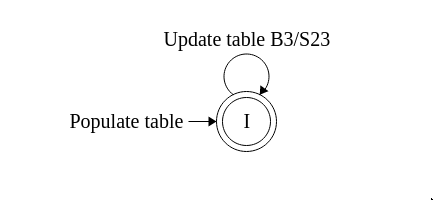

Ou seja, temos uma Máquina de Estados finita definida do seguinte modo:
$$\langle Q, \delta, S \rangle\ ;\ Q := \{I\}\ ,\ \delta := \{ (I,I)\}\ ,\ S := \{I\} $$

In [8]:
def trans(s, s_, N, table):
    return And(update_table(s, s_, N, table))


Estamos finalmente em vias de resolver algum modo de animar o nosso problema, tentaremos,
então animar a primeira configuração do Autómato Celular a ser estudado:

Comecemos por definir uma subrotina que preencha o traço com estados válidos representantes de um tabuleiro do Jogo:

In [12]:
def generate_trace(trace, M, init, N, table):
    init = init(N,table,trace)
    with Solver() as solver:
        res = False;
        prop = init
        for t_ind in range(M-1):
            state = trace[t_ind]
            solver.push()
            solver.add_assertion(prop);
            if solver.solve():
                trace[t_ind].living = [table[i][j]
                                       for j in range(1,N+1)
                                       for i in range(1, N+1)
                                       if solver.get_value(table[i][j]).constant_value()]
                trace[t_ind].border = [table[i][j]
                                           for j in range(N+1)
                                           for i in range(N+1)
                                           if (i == 0 or j == 0)
                                                and solver.get_value(table[i][j]).constant_value()]
                prop = trans(trace[t_ind], trace[t_ind+1], N, table)
            solver.pop()
        solver.add_assertion(prop);
        if solver.solve():
            trace[-1].living = [table[i][j]
                                   for j in range(1,N+1)
                                   for i in range(1, N+1)
                                   if solver.get_value(table[i][j]).constant_value()]
            trace[-1].border = [table[i][j]
                                   for j in range(N+1)
                                   for i in range(N+1)
                                   if (i == 0 or j == 0)
                                and solver.get_value(table[i][j]).constant_value()]

Trivialmente, através de `matplotlib`, podemos criar uma imagem que permite, assim, animar o tabuleiro:

In [13]:
def animate_trace(trace, t_ind, N, table):
    state = trace[t_ind]
    living = list()
    for i in range(N+1):
        living.append([])
        for j in range(N+1):
            if (table[i][j] in state.living
                or table[i][j] in state.border):
                living[i].append(True)
            else:
                living[i].append(False)
    plt.matshow(living , cmap='gray')


E, finalmente temos a nossa configuração inicial e algumas iterações mais do Jogo da Vida.

Esta será a configuração inicial que utilizaremos para provar as propriedades do enunciado.

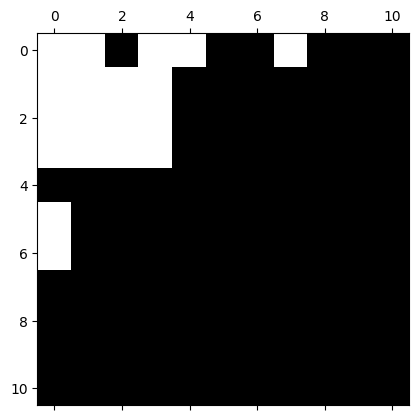

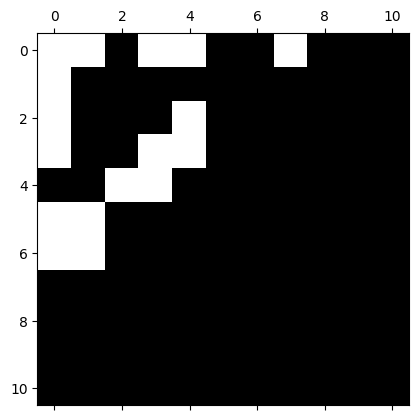

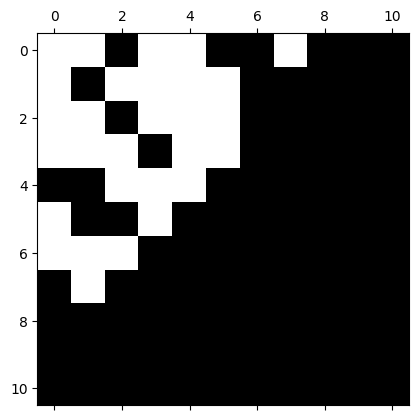

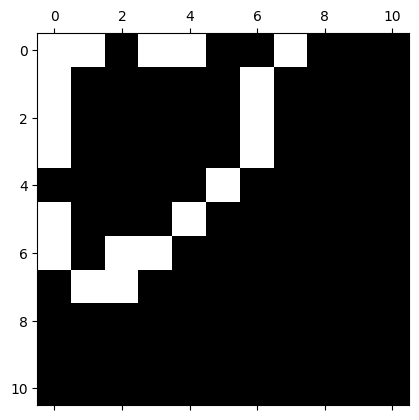

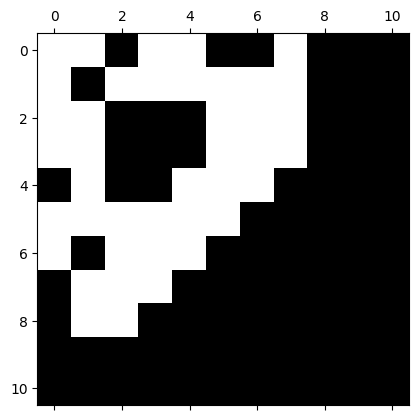

In [14]:
generate_trace(trace, M, init, N, table)
for i in range(5):
    animate_trace(trace, i, N, table)

## Verificação das Propriedades

Passaremos agora para a segunda parte do exercício, a prova de duas propriedades.

Consideremos, então, as proposições que queremos provar:

        1. Nunca se alcança o estado de erro
        2. Nenhuma célula normal está permanentemente morta ou permanentemente viva.

Notemos que é possivel encontrar proposições em lógicas SMT e FOL exatamente equivalentes às anteriores, nomeadamente:

        1. A existência de uma célula viva em qualquer estado do traço é sat;
        2. A eventual alteração de estado pelo menos uma vez de todas as células ao longo do traço é sat.

Que por sua vez podemos negar de tal forma a poder utilizar em algoritmos BMC:

        1. A variável `living` estar vazia em algum estado do traço é unsat;
        2. Existir alguma célula invariável ao longo do traço é unsat.

De salientar a linguagem usada nestas propriedades, "eventual" e "qualquer", sendo assim, temos que podemos utilizar
uma função `bmc_always` para $1$, sendo esta uma invariante do problema e `bmc_eventually` para $2$.

Definemos:

In [17]:
def bmc_always(init, trans,inv,M,N,trace, table):
    #generate_trace(trace, M, init, N, table)
    for k in range(M):
        with Solver(name="z3") as s:
            s.add_assertion(inv(trace, M, N, table, k-1))
            if s.solve():
                print(f"> A propriedade não é invariante para traço de tamanho {M}.")
                print([state.living for state in trace])
                return
    print(f"> A propriedade é invariante para traço de tamanho {M}.")

In [18]:
def bmc_eventually(init, trans,prop,M,N,trace, table):

    with Solver() as solver:
           
        never_occurs = Not(prop(trace, M, N, table, 0))
        solver.add_assertion(never_occurs)

        if solver.solve():
            print(f"> A propriedade não se verifica para traço de tamanho {M}.")
            return
        else:
            print(f"> A propriedade verifica-se para traço de tamanho {M}.")

A tradução da negação dos problemas vistos previamente para código PySMT é trivial:

In [19]:
def prop1(trace, M, N, table, ind):
    return Equals(Int(len(trace[ind].living)), Int(0))

De notar, no entanto, o modo como se verifica se existem células sem alterações no traço, isto é:

$$n := \sum_{k=0}^{\#\text{trace}} 1 \times (\text{table[i][j]} \in \text{trace[k].living}?), \forall_{(i,j) \in N \uparrow 2}$$
$$ n = \#\text{trace} \vee n = 0$$

Onde o primeiro caso denota a permanência de uma célula num estado vivo e o segundo a permanência como célula morta.

In [20]:
def prop2(trace, M, N, table, ind):
    return And(And(Not(Equals(Int(sum(table[i][j] in trace[k].living for k in range(M))), Int(M))),
                  Not(Equals(Int(sum(table[i][j] in trace[k].living for k in range(M))), Int(0)))
              )
            for i in range(1, N+1) for j in range(1, N+1))

Com isto só nos resta verificar a validade das propriedades:

In [21]:
bmc_always(init, trans,prop1,M,N,trace, table)

> A propriedade é invariante para traço de tamanho 19.


In [22]:
bmc_eventually(init, trans,prop2 ,M,N,trace, table)

> A propriedade verifica-se para traço de tamanho 19.


Visualizemos o traço deste exemplo na sua totalidade:

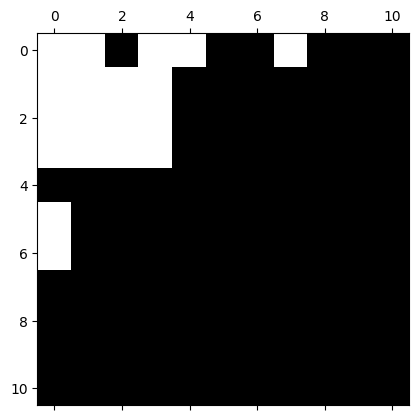

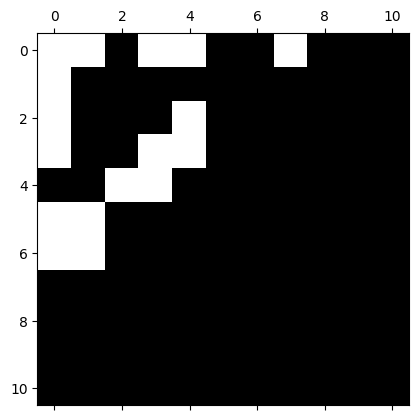

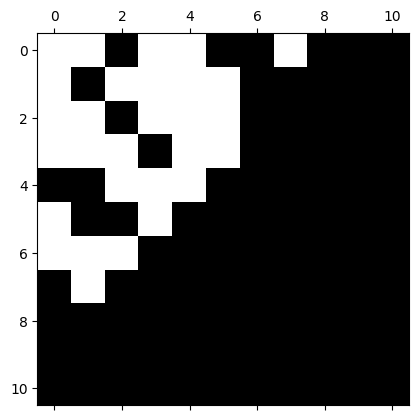

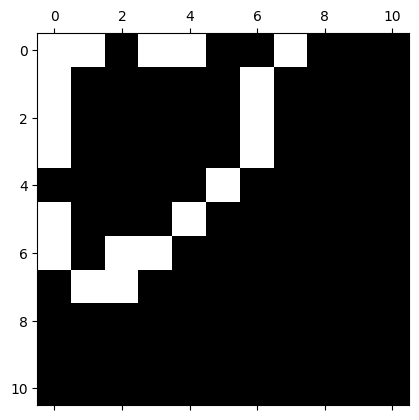

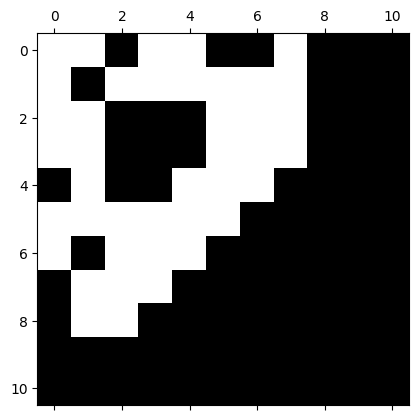

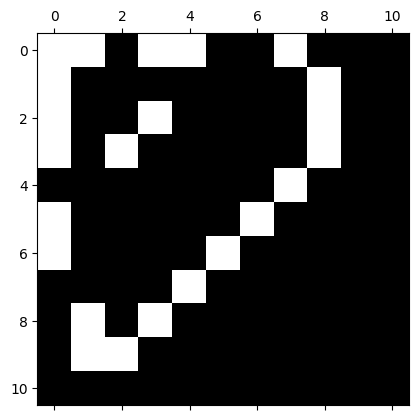

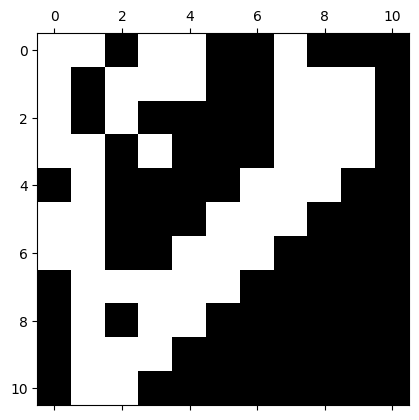

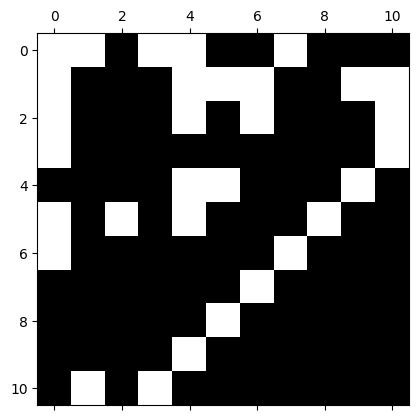

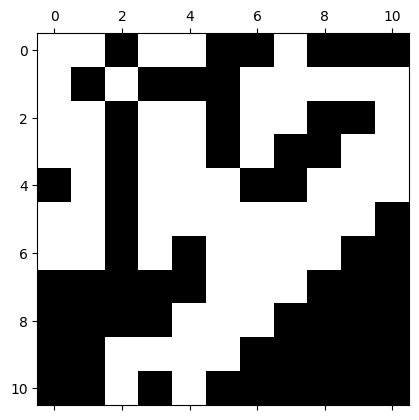

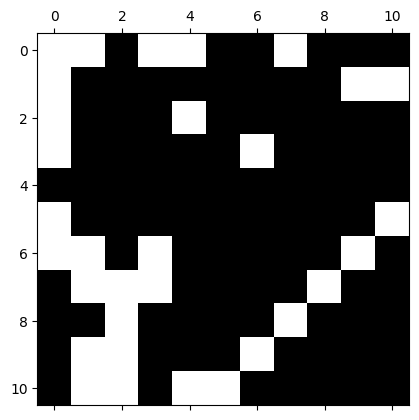

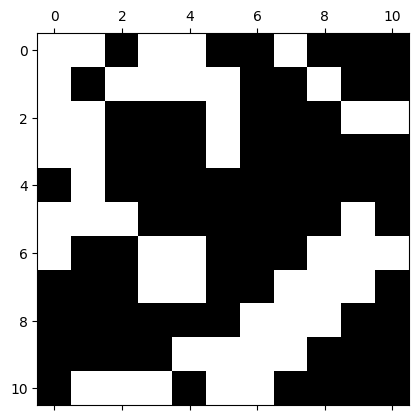

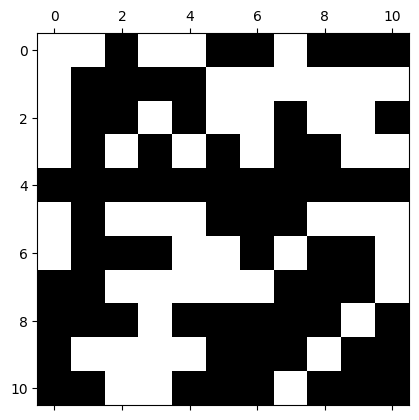

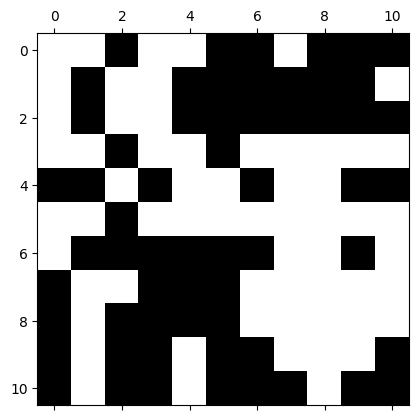

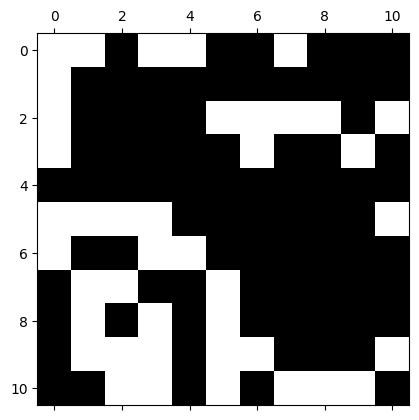

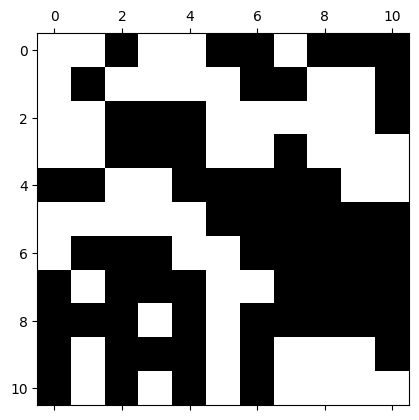

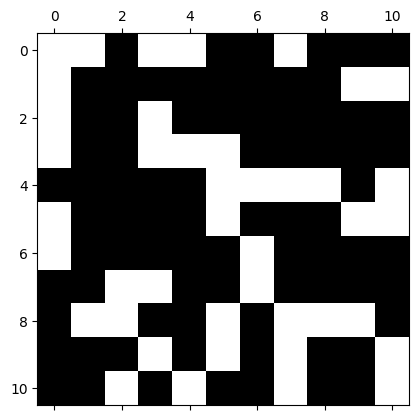

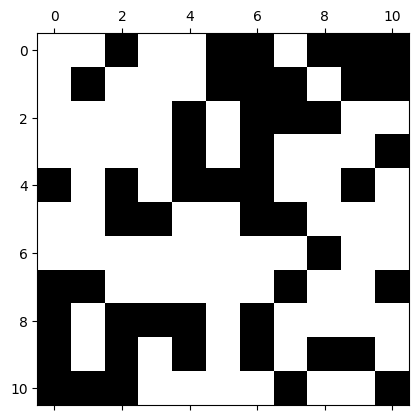

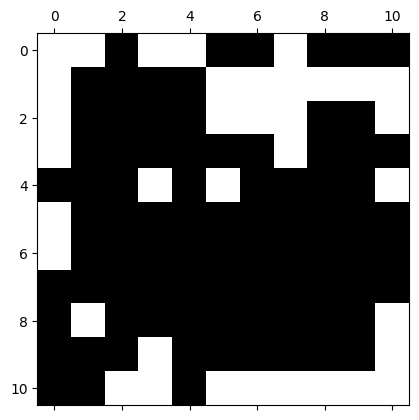

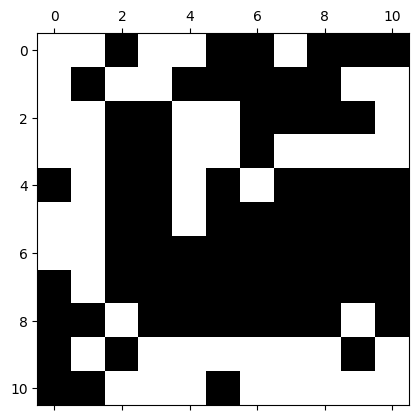

In [25]:
for i in range(M):
    animate_trace(trace, i, N, table)

## Exercício 2: Testes

> A propriedade é invariante para traço de tamanho 15.
> A propriedade verifica-se para traço de tamanho 15.


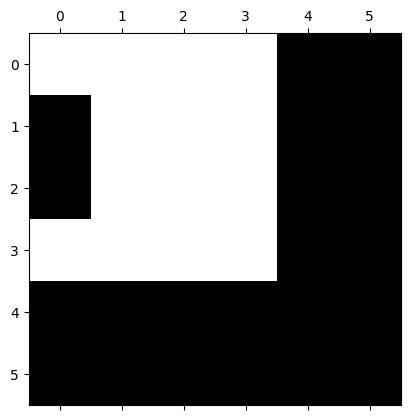

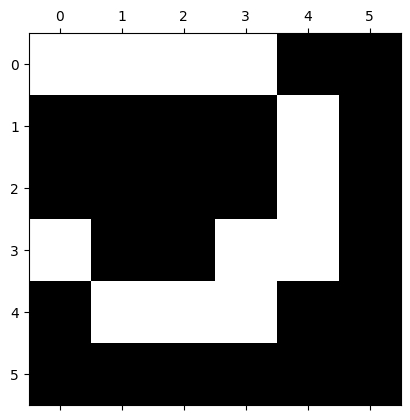

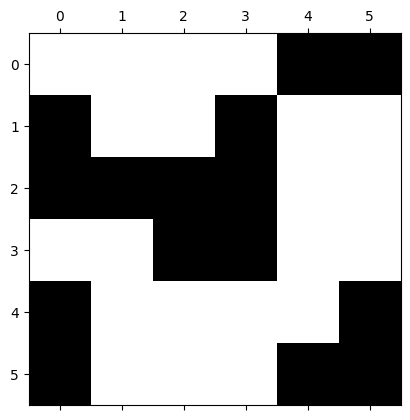

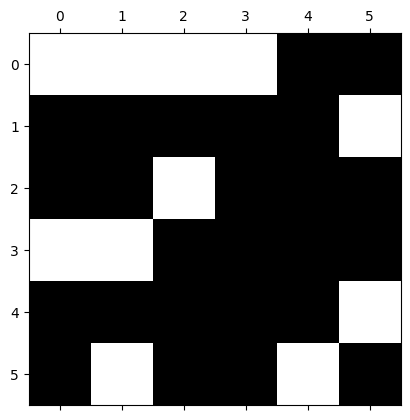

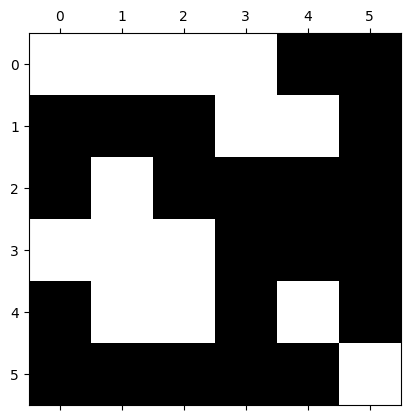

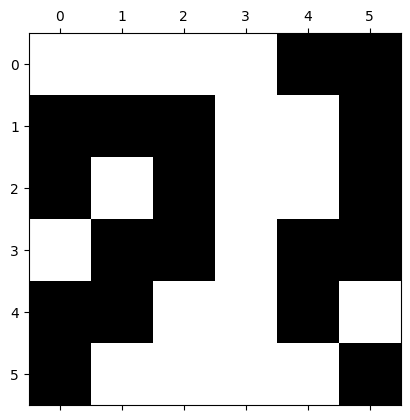

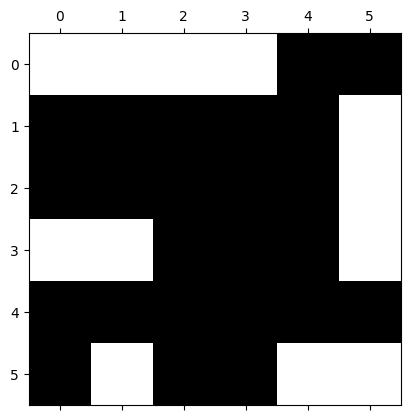

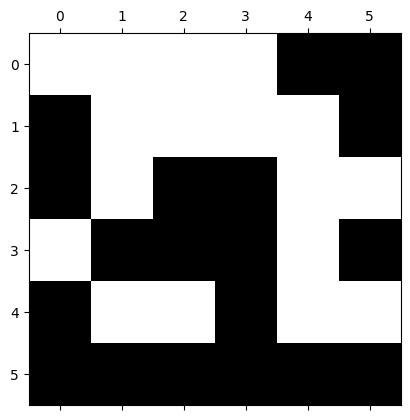

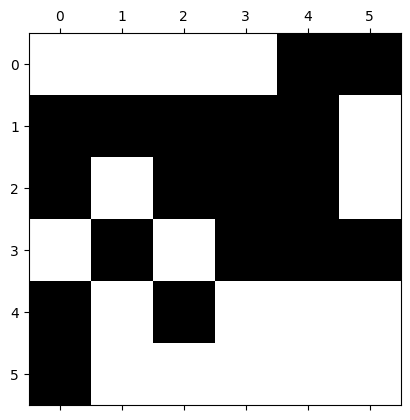

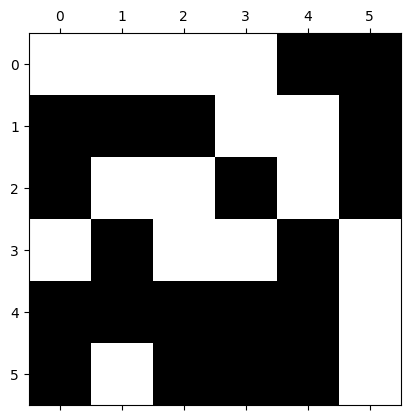

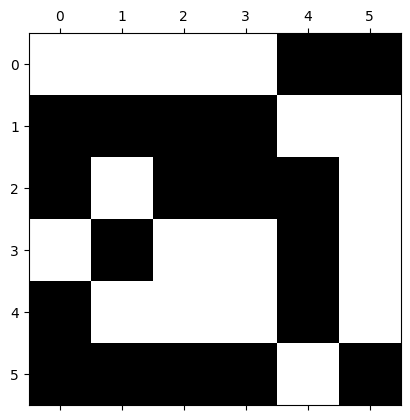

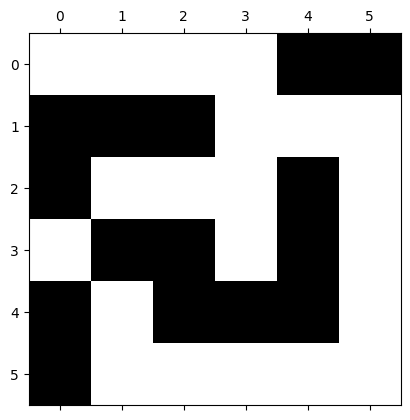

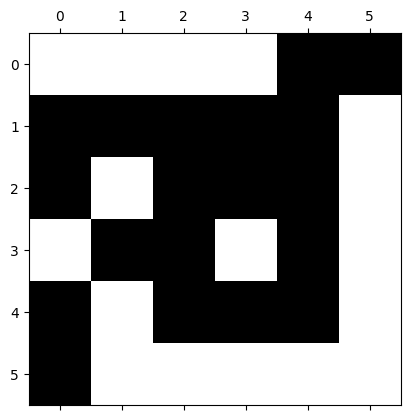

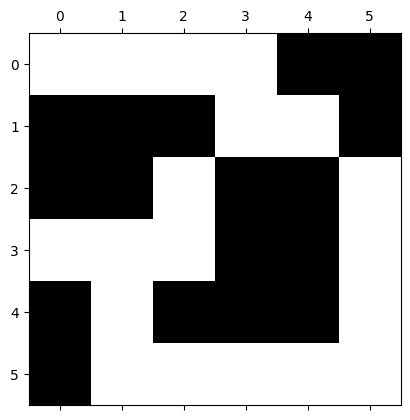

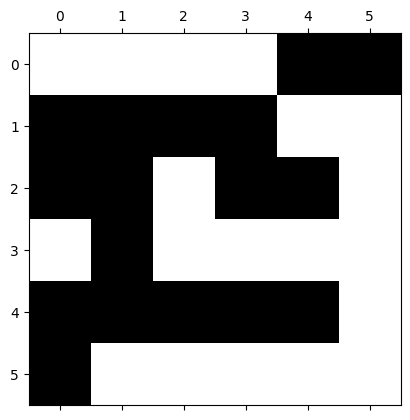

In [30]:
N = 5
table = [[Symbol('c'+str(i)+','+str(j)) for j in range(N+1)] for i in range(N+1)]
M = 15
trace= [ST('ST'+str(i)) for i in range(M)]
generate_trace(trace, M, init, N, table)
bmc_always(init, trans,prop1,M,N,trace, table)
bmc_eventually(init, trans,prop2 ,M,N,trace, table)
for i in range(M):
    animate_trace(trace, i, N, table)

> A propriedade é invariante para traço de tamanho 49.
> A propriedade verifica-se para traço de tamanho 49.


/tmp/ipykernel_14463/1621384587.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(living , cmap='gray')


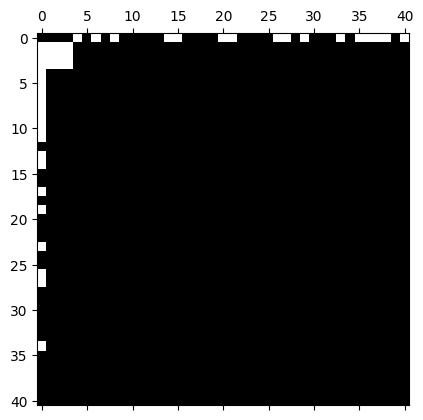

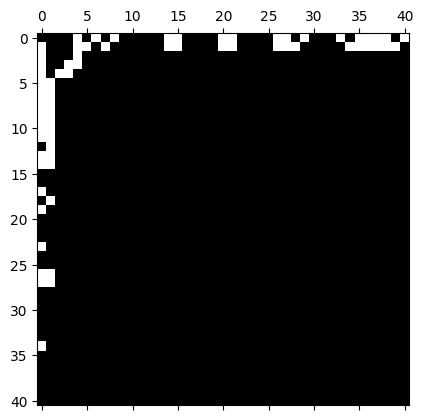

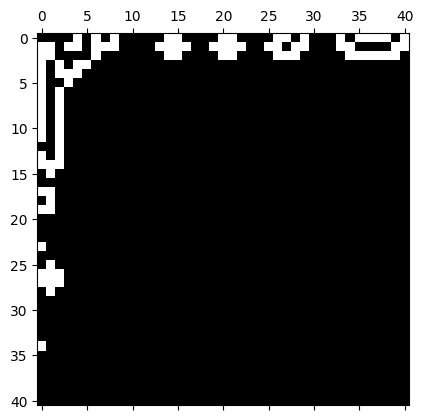

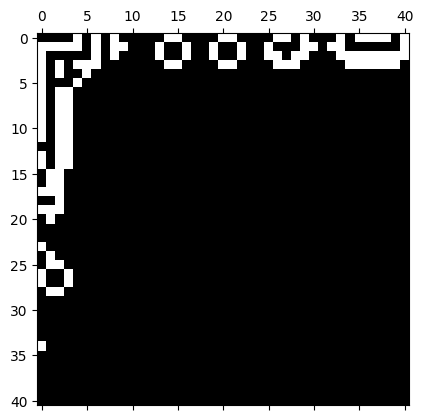

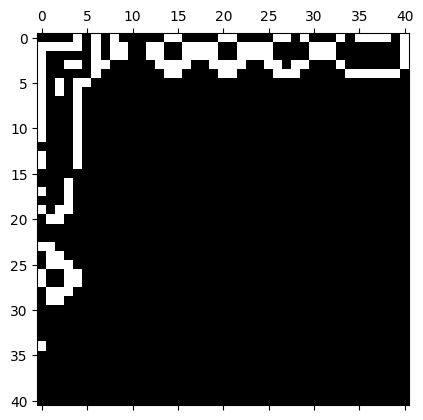

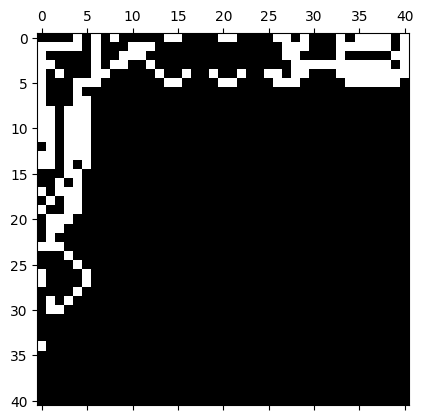

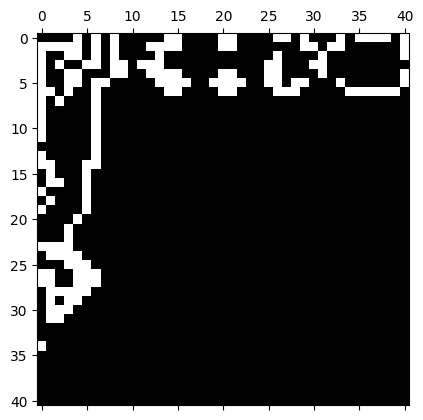

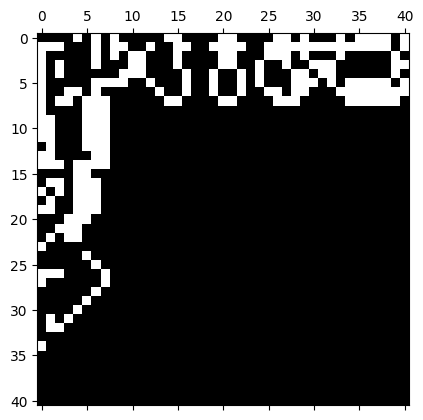

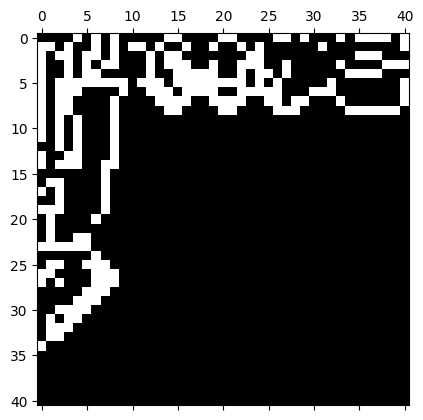

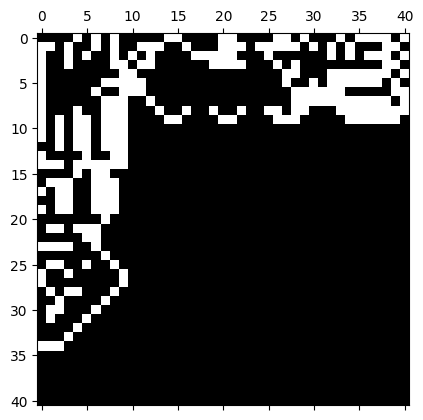

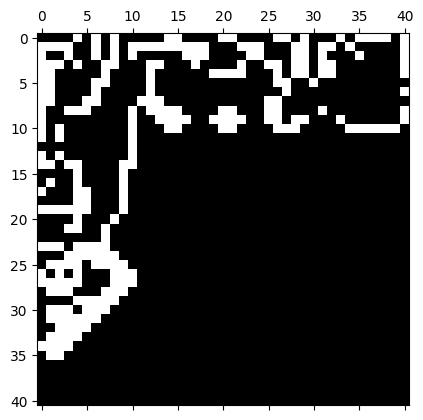

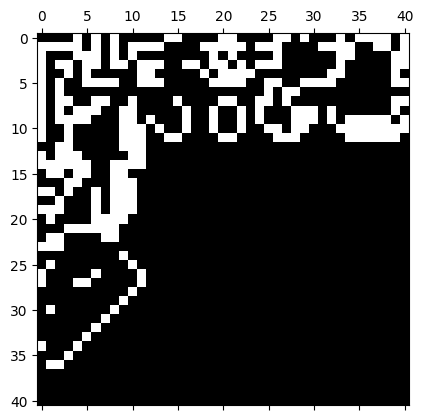

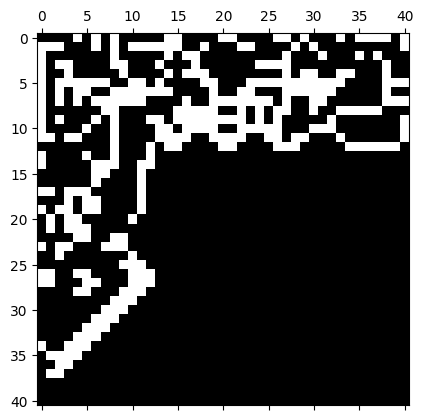

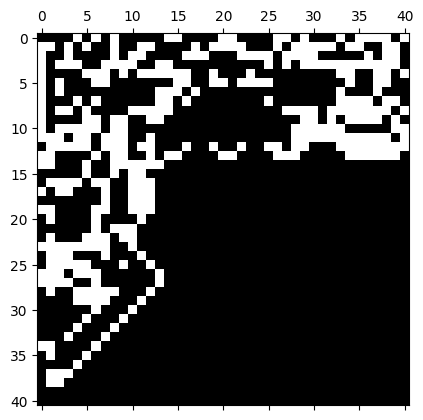

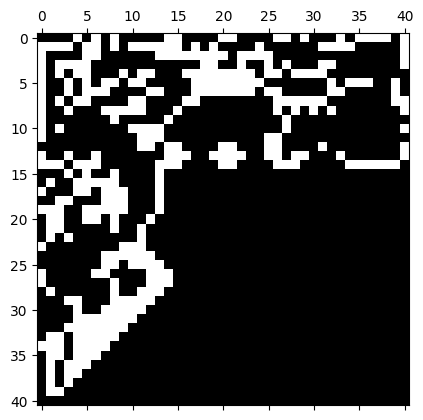

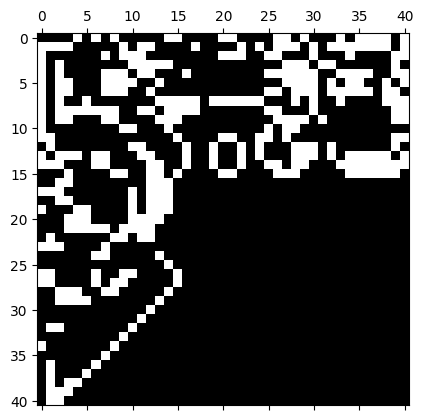

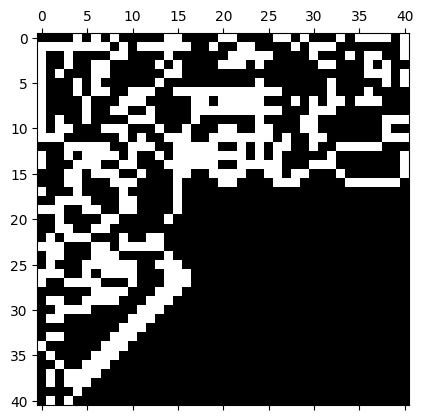

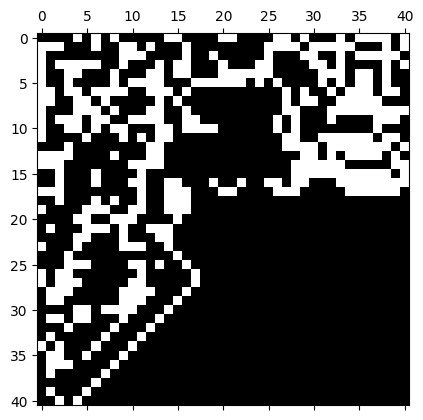

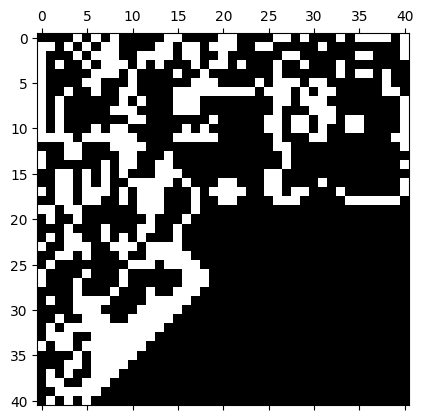

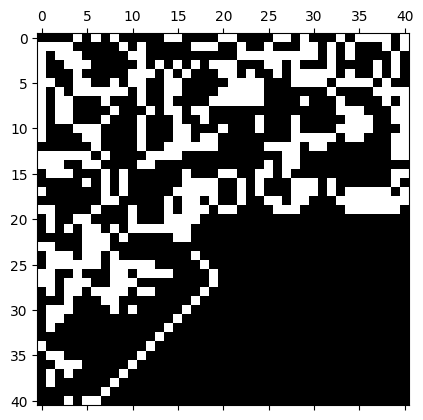

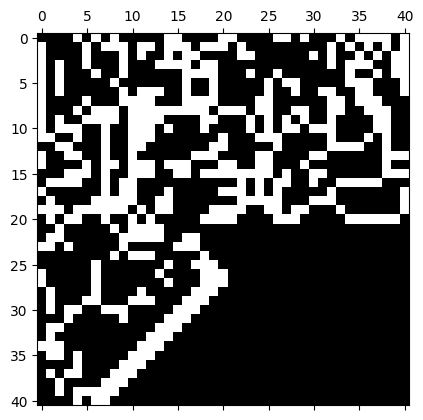

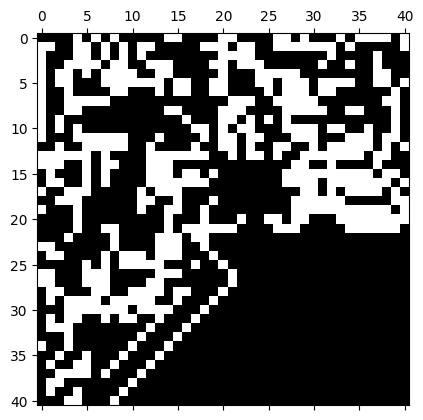

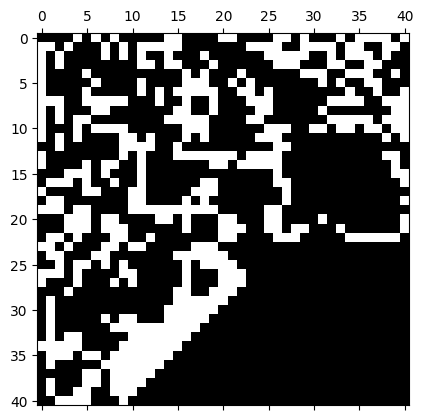

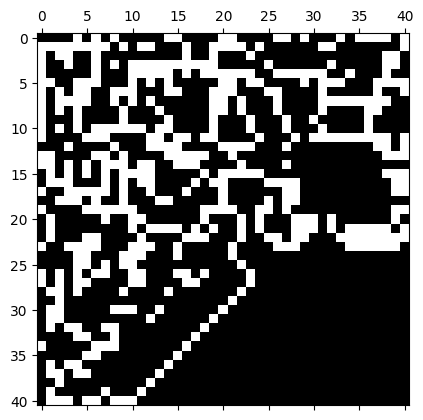

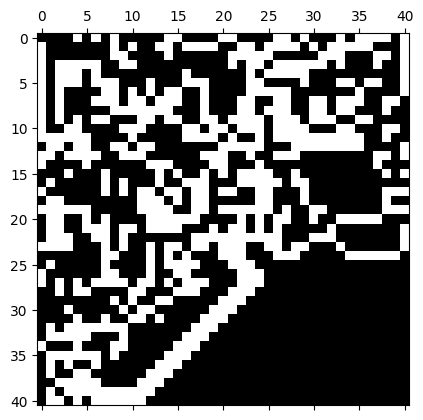

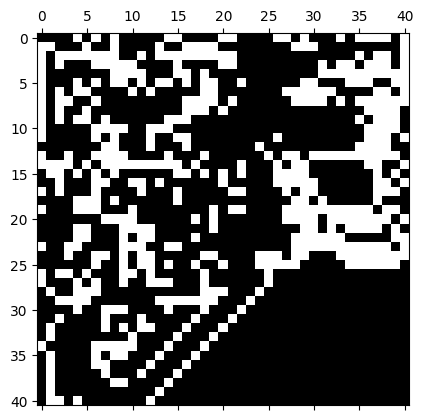

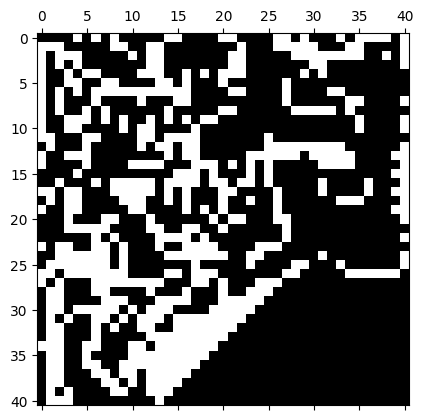

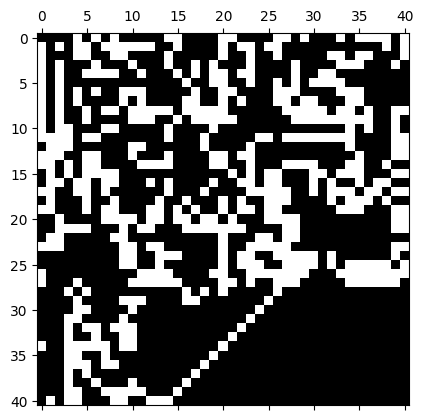

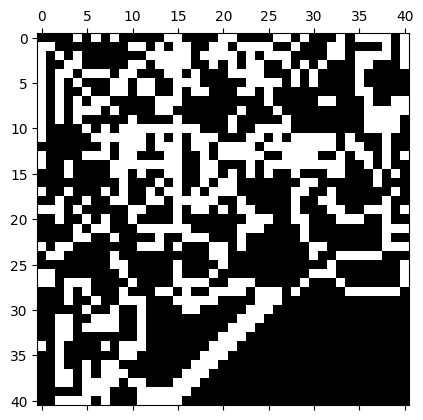

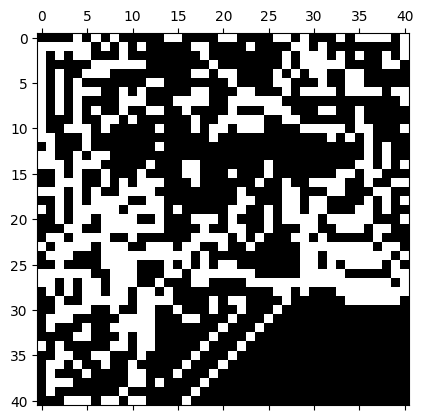

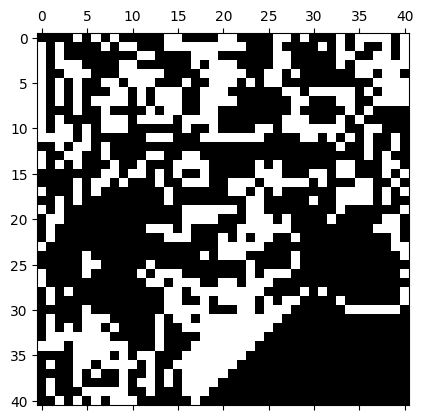

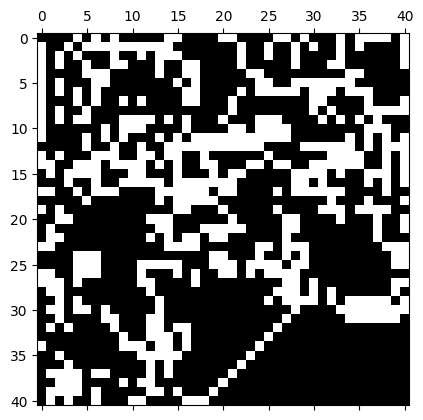

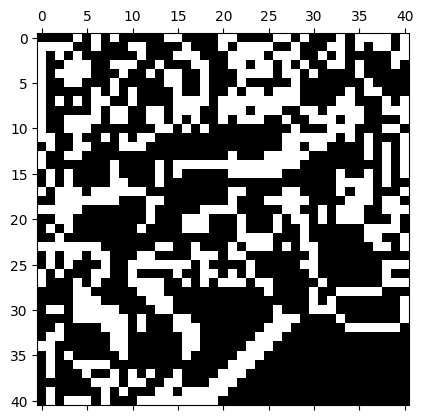

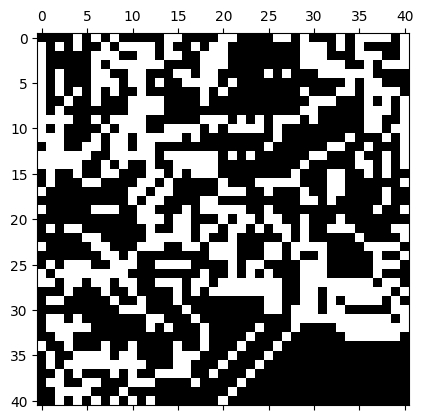

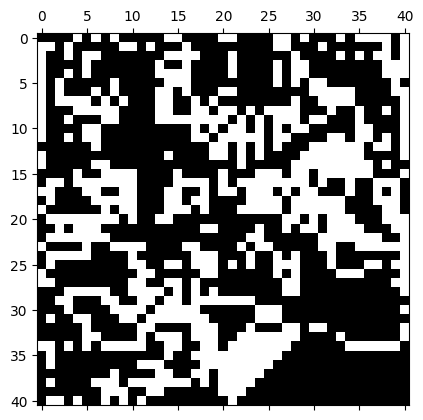

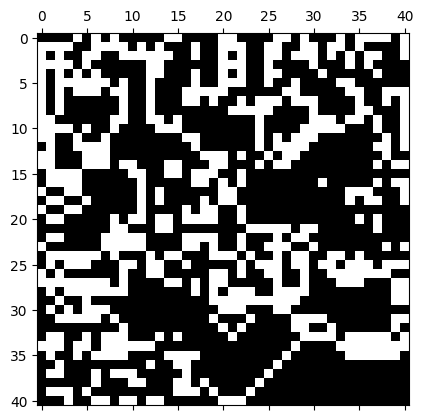

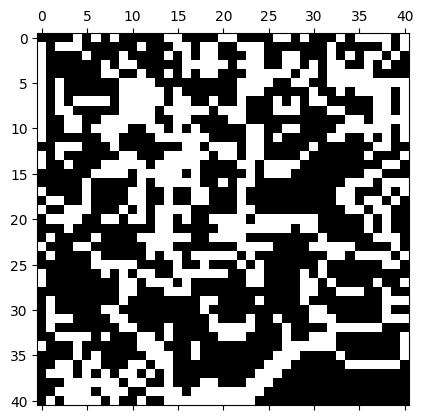

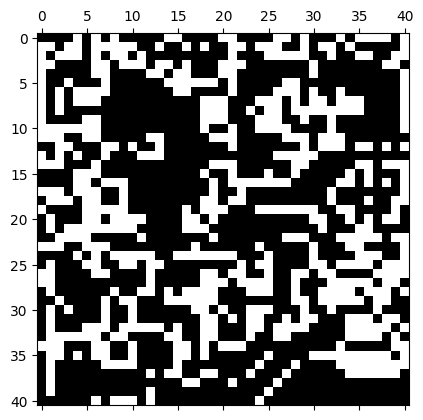

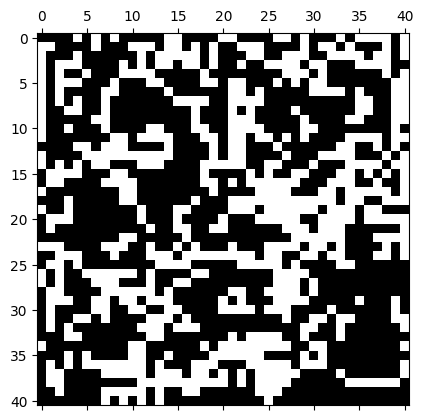

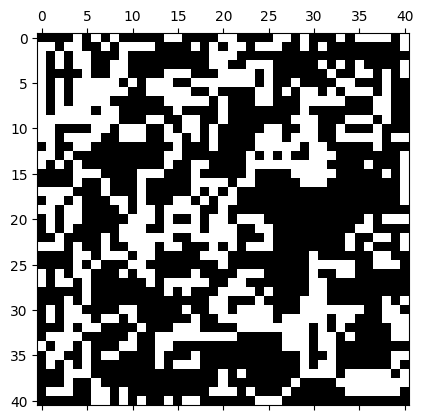

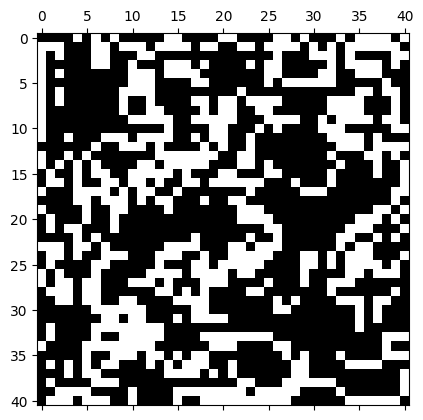

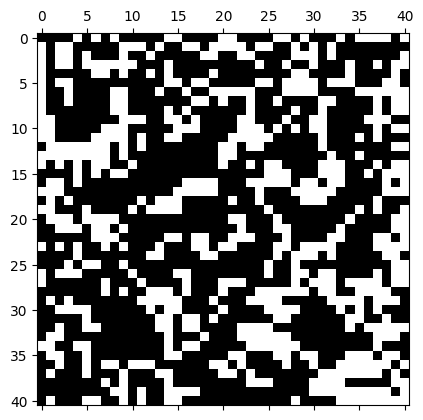

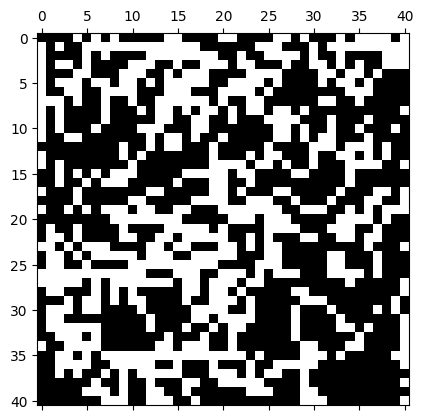

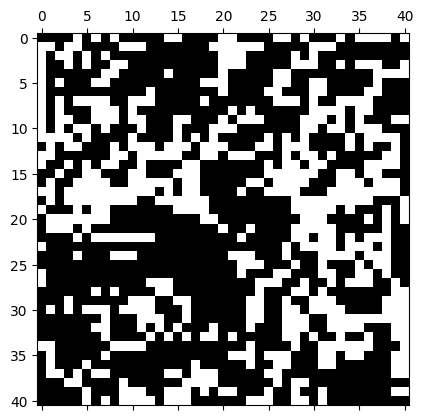

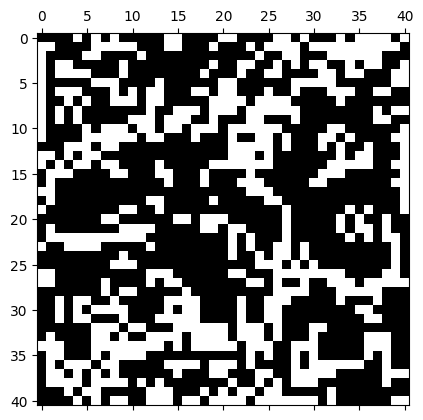

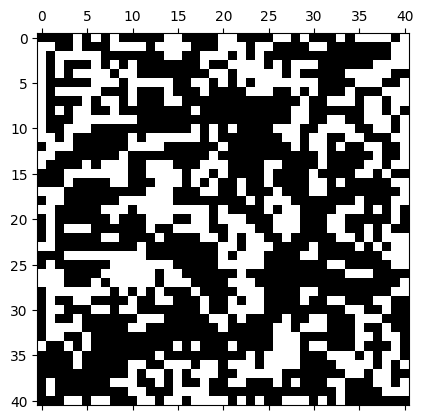

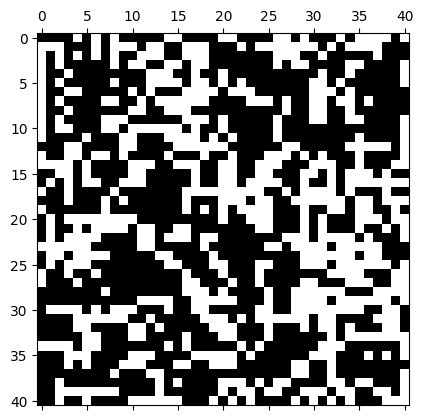

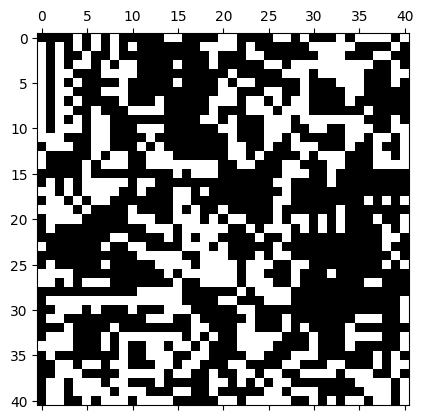

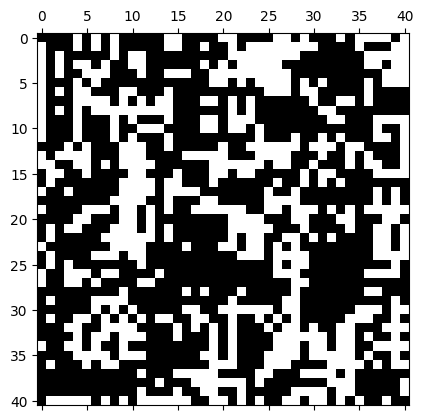

In [31]:
N = 40
table = [[Symbol('c'+str(i)+','+str(j)) for j in range(N+1)] for i in range(N+1)]
M = 49
trace= [ST('ST'+str(i)) for i in range(M)]
generate_trace(trace, M, init, N, table)
bmc_always(init, trans,prop1,M,N,trace, table)
bmc_eventually(init, trans,prop2 ,M,N,trace, table)
for i in range(M):
    animate_trace(trace, i, N, table)